In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers,Sequential
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from QSAR_package.data_split import randomSpliter
from QSAR_package.feature_preprocess import correlationSelection
from QSAR_package.data_scale import dataScale
from QSAR_package.model_evaluation import modelEvaluator
from time import time
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from IPython.display import clear_output

Using TensorFlow backend.


In [2]:
def Sec2Time(seconds):  # convert seconds to time
    m, s = divmod(int(seconds), 60)
    h, m = divmod(m, 60)
    return ("{:02d}h:{:02d}m:{:02d}s".format(h, m, s))

In [3]:
data_path = "C:/OneDrive/Jupyter_notebook/regression_new/data/spla2_296_rdkit2d.csv"

# 提取数据，随机分训练集测试集
spliter = randomSpliter(test_size=0.25,validation_size=None,random_state=0)
spliter.ExtractTotalData(data_path,label_name='pIC50')
spliter.SplitData()
tr_x = spliter.tr_x
tr_y = spliter.tr_y
# val_y = spliter.val_y
te_y = spliter.te_y

# 相关性筛选
corr = correlationSelection()
corr.PearsonXX(tr_x, tr_y)

# 压缩
scaler = dataScale(scale_range=(0.1, 0.9))
tr_scaled_x = scaler.FitTransform(corr.selected_tr_x)
# val_scaled_x = scaler.Transform(spliter.val_x,DataSet='validation')
te_scaled_x = scaler.Transform(spliter.te_x,DataSet='test')

print('train: {}\ntest: {}'.format(len(tr_scaled_x),len(te_scaled_x)))
# print('train: {}\nvalidation: {}\ntest: {}'.format(len(tr_scaled_x),len(val_scaled_x),len(te_scaled_x)))

train: 222
test: 74


In [4]:
print(tr_scaled_x.columns.shape)

(71,)


In [5]:
# 把原始训练集分成若干组小训练集和验证集
rs = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
rs.get_n_splits(tr_y)
tr_idxs = []
va_idxs = []
for train_index, test_index in rs.split(tr_y):
    tr_idxs.append(train_index)
    va_idxs.append(test_index)

In [6]:
tr_x_input = tr_scaled_x.iloc[tr_idxs[4],:]
va_x_input = tr_scaled_x.iloc[va_idxs[4],:]

In [8]:
# 自定义的回调函数——实时显示loss变化图
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, c='b',lw=1,label="loss")
        plt.plot(self.x, self.val_losses, c='r',lw=1,label="val_loss")
        plt.legend()
        plt.show();
        
    def on_train_end(self, logs={}):
        print('Training complete')
        
plot_losses = PlotLosses()

In [12]:
# 构建网络结构
tf.keras.backend.clear_session()
t0 = time()
model = Sequential()
model.add(layers.Dense(units=20,activation='relu',name='Layer1',input_shape=(tr_scaled_x.shape[1],)))
model.add(layers.Dense(units=20,activation='relu',name='Layer2'))
model.add(layers.Dense(units=1,activation='relu',name='OutputLayer'))

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
             loss='mse',metrics=['mae'])
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0,patience=30, verbose=0,mode='auto')

# tb = TensorBoard(log_dir='./logs',  # log 目录
#                  histogram_freq=1,  # 按照何等频率（epoch）来计算直方图，0为不计算
#                  batch_size=32,     # 用多大量的数据计算直方图
#                  write_graph=True,  # 是否存储网络结构图
#                  write_grads=False, # 是否可视化梯度直方图
#                  write_images=False,# 是否可视化参数
#                  embeddings_freq=0, 
#                  embeddings_layer_names=None, 
#                  embeddings_metadata=None)

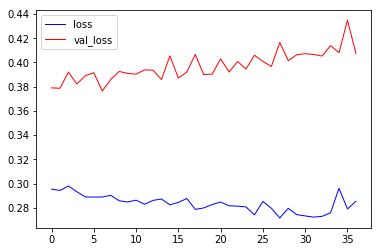

Training complete
00h:00m:39s


In [13]:
# 训练模型（利用若干组小训练集和验证集重复训练与early_stop）
history = []
val_pred = []
val_y = []
for i in range(len(tr_idxs)):
    tr_x_input = tr_scaled_x.iloc[tr_idxs[i],:].values
    tr_y_input = tr_y.iloc[tr_idxs[i]].values
    va_x_input = tr_scaled_x.iloc[va_idxs[i],:].values
    va_y_input = tr_y.iloc[va_idxs[i]].values
    history.append(model.fit(x=tr_x_input,y=tr_y_input,epochs=2000,validation_data=(va_x_input,va_y_input),
                        verbose=0,callbacks=[early_stopping,plot_losses]))
    val_pred.extend(model.predict(x=va_x_input).flatten())
    val_y.extend(va_y_input)
    print(Sec2Time(time()-t0))

In [14]:
# 获取预测结果
tr_pred = model.predict(x=tr_scaled_x.values).flatten()
# val_pred = model.predict(x=val_scaled_x.values).flatten()
te_pred = model.predict(x=te_scaled_x.values).flatten()

In [16]:
# 评价预测结果
tr_Evaluator = modelEvaluator(tr_y, tr_pred)
val_Evaluator = modelEvaluator(val_y, val_pred)
te_Evaluator = modelEvaluator(te_y, te_pred)
print(tr_Evaluator.r2,tr_Evaluator.rmse)
print(val_Evaluator.r2,val_Evaluator.rmse)
print(te_Evaluator.r2,te_Evaluator.rmse)

0.7766 0.547
0.692 0.6681
0.7197 0.6419


In [38]:
# 保存预测结果
pred_results = pd.DataFrame([tr_y.values,tr_pred,val_y,val_pred,te_y.values,te_pred],
                            index=['tr_y','tr_pred','val_y','val_pred','te_y','te_pred']).T
pred_results.to_csv('./pred_results.csv',index=False)

In [28]:
# 保存模型文件
model.save('./model_sPLA2_rgr.h5')

In [34]:
# 重新导入模型并预测
model_load = load_model('./model_sPLA2_rgr.h5')

tr_pred = model_load.predict(x=tr_scaled_x.values).flatten()
te_pred = model_load.predict(x=te_scaled_x.values).flatten()
te_Evaluator = modelEvaluator(te_y, te_pred)
# val_Evaluator = modelEvaluator(val_y, val_pred, model_kind='rgr')
tr_Evaluator = modelEvaluator(tr_y, tr_pred)
print(tr_Evaluator.r2,tr_Evaluator.rmse)
# print(val_Evaluator.r2,val_Evaluator.mse)
print(te_Evaluator.r2,te_Evaluator.rmse)

0.7949 0.5241
0.6913 0.6736


In [ ]:
# 重新读取预测结果
pred_data = pd.read_csv("C:/OneDrive/Jupyter_notebook/regression_new/DL_results/pred_results_120.csv").fillna('None')
tr_y = pred_data.tr_y[pred_data.tr_y!='None']
tr_pred = pred_data.tr_pred[pred_data.tr_pred!='None']
te_y = pred_data.te_y[pred_data.te_y!='None']
te_pred = pred_data.te_pred[pred_data.te_pred!='None']

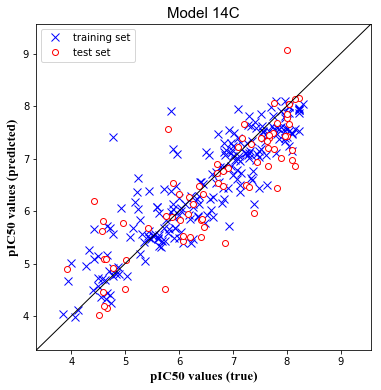

In [39]:
# 画散点图
fig = plt.figure(figsize=(6,6))
axisMin = min(tr_y.min(),te_y.min(),tr_pred.min(),te_pred.min())-0.5
axisMax = max(tr_y.max(),te_y.max(),tr_pred.max(),te_pred.max())+0.5
plt.plot(tr_y,tr_pred,'xb',markersize=8)
plt.plot(te_y,te_pred,'or',mfc='w',markersize=6)
plt.plot([axisMin,axisMax],[axisMin,axisMax],'k',lw=1)
plt.axis([axisMin,axisMax,axisMin,axisMax])
plt.xlabel('pIC50 values (true)',fontproperties='Times New Roman',fontsize=13)
plt.ylabel('pIC50 values (predicted)',fontproperties='Times New Roman',fontsize=13)
plt.legend(['training set', 'test set'], loc='best')
plt.title('Model 14C',fontproperties='Arial',fontsize=15)
# plt.savefig('C:/OneDrive/Jupyter_notebook/regression_new/DL_results/scatter_fig_title_{}.tif'.format(120),
#             dpi=300,bbox_inches='tight')
plt.show()

In [21]:
# 从history获取每个epoch的loss值
tr_loss = []
va_loss = []
tr_loss_flat = []
va_loss_flat = []
for i in range(len(history)):
    tr_loss.append(history[i].history['loss'])
    va_loss.append(history[i].history['val_loss'])
    tr_loss_flat.extend(history[i].history['loss'])
    va_loss_flat.extend(history[i].history['val_loss'])

step = 0
flag = [0]
for i in range(len(tr_loss)-1):
    step = step+len(tr_loss[i])
    flag.append(step)
flag.append(len(tr_loss_flat))

In [ ]:
#==============保存loss值文件============#
# tr_loss_df = pd.DataFrame(tr_loss,index=['fold_{}'.format(i+1) for i in range(len(tr_loss))]).T
# val_loss_df = pd.DataFrame(va_loss,index=['fold_{}'.format(i+1) for i in range(len(va_loss))]).T

# tr_loss_df.to_csv('./sPLA2_rgr/tr_loss.csv',index=False)
# val_loss_df.to_csv('./sPLA2_rgr/val_loss.csv',index=False)

In [18]:
###========重新读入loss值文件画图=============#
# data1 = pd.read_csv("C:/OneDrive/Jupyter_notebook/regression_new/DL_results/tr_loss_0.csv").fillna('None')
# data2 = pd.read_csv('C:/OneDrive/Jupyter_notebook/regression_new/DL_results/val_loss_0.csv').fillna('None')

# tr_loss = []
# va_loss = []
# tr_loss_flat = []
# va_loss_flat = []
# for i in range(len(data1.columns)):
#     values1 = [d for d in data1.iloc[:,i] if d is not 'None']
#     values2 = [d for d in data2.iloc[:,i] if d is not 'None']
#     tr_loss.append(values1)
#     tr_loss_flat.extend(values1)
#     va_loss.append(values2)
#     va_loss_flat.extend(values2)
# step = 0
# flag = [0]
# for i in range(len(tr_loss)-1):
#     step = step+len(tr_loss[i])
#     flag.append(step)
# flag.append(len(tr_loss_flat))

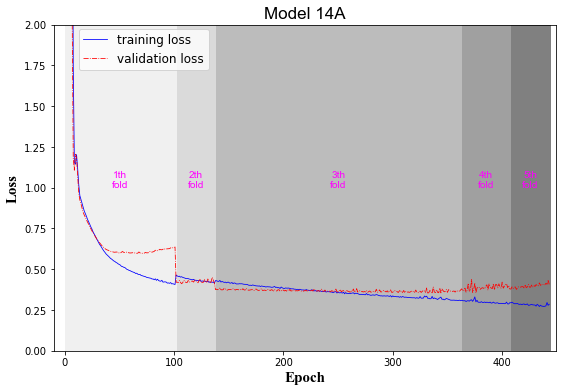

In [23]:
# 绘制所有训练过程的loss变化图
h = 0.05
x_min = 0
x_max = len(tr_loss_flat)
y_min = min(tr_loss_flat)-1
y_max = max(tr_loss_flat)+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = np.zeros_like(xx)

for i in range(len(flag)-1):
    Z[np.where((flag[i]<xx)&(xx<=flag[i+1]))] = i+1

fig = plt.figure(figsize=(9,6))
plt.plot(tr_loss_flat,c='b',ls='solid',lw=0.8)
plt.plot(va_loss_flat,c='r',ls='-.',lw=0.8)
plt.imshow(Z, interpolation='nearest',alpha=0.5,
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Greys,
           aspect='auto', origin='lower')
plt.title('Model Prediction Loss (MSE)',fontproperties='Arial',
          fontsize=15,fontstyle='normal')
plt.xlim(-10,x_max+5)
plt.ylim(0,2)
for i in range(len(flag)-1):
    plt.text(np.average(flag[i:i+2]), 1, '{}th\nfold'.format(i+1), fontsize=5,color='#FF00FF',
             fontproperties='Arial',rasterized=True,horizontalalignment='center')
plt.ylabel('Loss',fontproperties='Times New Roman',fontsize=15)
plt.xlabel('Epoch',fontproperties='Times New Roman',fontsize=15)
plt.title('Model 14A',fontproperties='Arial',fontsize=17)
plt.legend(['training loss', 'validation loss'], loc=(0.05,0.86),fontsize=12)
# plt.savefig('C:/OneDrive/Jupyter_notebook/regression_new/DL_results/loss_fig_title_0.tif',dpi=300,bbox_inches='tight')
plt.show()

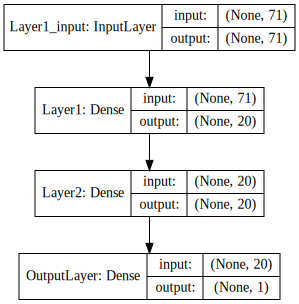

In [24]:
# 生成神经网络的结构图
# plot_model(model,to_file='./sPLA2_rgr/model.png',show_shapes=True,rankdir='TB')
im = SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
im

In [ ]:
import cairosvg

In [ ]:
# 保存高清的神经网络结构图
with open('./temp.svg','w') as f:
    f.write(im.data)
cairosvg.svg2png( url='./temp.svg', dpi=600, scale=4,
                 write_to='C:/OneDrive/Jupyter_notebook/drugbank/figures/mlp_model_structure.png' )